# 🧠 Personality Classification - Data Leakage Prevention

## 📋 Mục tiêu
Notebook này cải tiến phương pháp gốc bằng cách **ngăn chặn Data Leakage** thông qua việc tách dữ liệu theo **user-level** thay vì **sample-level**.

## 🔍 Vấn đề Data Leakage trong notebook gốc

Trong notebook gốc, mỗi user có **50 posts** được gộp lại thành 1 sample. Tuy nhiên, nếu ta tách train/test theo sample thông thường:
- Các posts của cùng một user có thể xuất hiện ở **cả train và test set**
- Model có thể học được **writing style** đặc trưng của từng user thay vì học các đặc điểm personality thực sự
- Điều này dẫn đến **overfitting** và kết quả đánh giá không phản ánh đúng khả năng generalization

## 🛠️ Giải pháp

1. **Tách posts riêng lẻ**: Thay vì gộp 50 posts/user, ta tách từng post riêng
2. **Group-based split**: Sử dụng `GroupShuffleSplit` để đảm bảo tất cả posts của 1 user chỉ xuất hiện trong train HOẶC test
3. **Fit TF-IDF chỉ trên train**: Tránh information leakage từ test set vào vocabulary

## 📊 Kỳ vọng
- Accuracy có thể **giảm** so với notebook gốc (vì không còn data leakage)
- Kết quả phản ánh **chính xác hơn** khả năng generalization của model


In [1]:
# ============================================
# 🔧 INSTALL DEPENDENCIES
# ============================================
%pip install -q imbalanced-learn xgboost wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ============================================
# 📚 IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# XGBoost
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries loaded!")

✅ All libraries loaded!


---
## 1. 📥 Load Dataset và Tách Posts theo User


In [3]:
# ============================================
# 📥 LOAD DATASET
# ============================================
dataset_url = 'https://raw.githubusercontent.com/ducnt3/IT4868E/refs/heads/master/mbti_1.csv'
df_original = pd.read_csv(dataset_url)
print(f"✅ Original dataset loaded: {df_original.shape[0]} users")
df_original.head()

✅ Original dataset loaded: 8675 users


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# ============================================
# 🔄 TÁCH POSTS RIÊNG LẺ (KEY CHANGE!)
# ============================================
# Trong dataset gốc, mỗi user có ~50 posts được nối bằng |||
# Ta sẽ tách ra thành các posts riêng lẻ để tránh data leakage

def split_posts_by_user(df):
    """Tách posts riêng lẻ và giữ user_id để group-based split"""
    rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Splitting posts"):
        posts = row['posts'].split('|||')
        for post in posts:
            post = post.strip()
            if len(post) > 10:  # Bỏ qua posts quá ngắn
                rows.append({
                    'user_id': idx,  # Giữ user_id để group split
                    'type': row['type'],
                    'post': post
                })
    return pd.DataFrame(rows)

df_posts = split_posts_by_user(df_original)
print(f"\n✅ Expanded dataset: {len(df_posts)} individual posts")
print(f"   From {df_posts['user_id'].nunique()} unique users")
print(f"   Average posts per user: {len(df_posts) / df_posts['user_id'].nunique():.1f}")
df_posts.head()

Splitting posts:   0%|          | 0/8675 [00:00<?, ?it/s]


✅ Expanded dataset: 413628 individual posts
   From 8675 unique users
   Average posts per user: 47.7


,user_id,type,post
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,INFJ,enfp and intj moments https://www.youtube.com...
3,0,INFJ,What has been the most life-changing experienc...
4,0,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [5]:
# ============================================
# 🧹 TEXT PREPROCESSING
# ============================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# MBTI types to remove (prevent data leakage!)
MBTI_TYPES = ['infj', 'infjs', 'entp', 'entps', 'intp', 'intps', 'intj', 'intjs',
              'entj', 'entjs', 'enfj', 'enfjs', 'infp', 'infps', 'enfp', 'enfps',
              'isfp', 'isfps', 'istp', 'istps', 'isfj', 'isfjs', 'istj', 'istjs',
              'estp', 'estps', 'esfp', 'esfps', 'estj', 'estjs', 'esfj', 'esfjs']
MBTI_PARTIAL = ['introvert', 'extrovert', 'intuitive', 'sensing', 'feeling', 
                'thinking', 'judging', 'perceiving', 'mbti', 'myers', 'briggs']

def clean_text(text):
    """Clean text for TF-IDF"""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove MBTI mentions (prevent data leakage)
    text_lower = text.lower()
    for mbti in MBTI_TYPES + MBTI_PARTIAL:
        text_lower = re.sub(r'\b' + mbti + r'\b', '', text_lower)
    
    # Heavy cleaning for TF-IDF
    text = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

print("Cleaning text...")
df_posts['clean_post'] = df_posts['post'].apply(clean_text)

# Loại bỏ posts rỗng sau khi clean
df_posts = df_posts[df_posts['clean_post'].str.len() > 0].reset_index(drop=True)
print(f"✅ Text cleaning complete! {len(df_posts)} posts remaining")

Cleaning text...
✅ Text cleaning complete! 400679 posts remaining


In [6]:
# ============================================
# 🎯 MAP MBTI TO BIG FIVE TRAITS
# ============================================
def map_mbti_to_big5(mbti_type):
    return {
        'Extraversion': 1 if 'E' in mbti_type else 0,
        'Openness': 1 if 'N' in mbti_type else 0,
        'Agreeableness': 1 if 'F' in mbti_type else 0,
        'Conscientiousness': 1 if 'J' in mbti_type else 0
    }

traits = df_posts['type'].apply(map_mbti_to_big5).apply(pd.Series)
df_posts = pd.concat([df_posts, traits], axis=1)

TARGET_TRAITS = ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

# Show class distribution
print("📊 Class Distribution (post-level):")
for trait in TARGET_TRAITS:
    counts = df_posts[trait].value_counts()
    print(f"   {trait}: 0={counts[0]}, 1={counts[1]} (ratio: {counts[1]/counts[0]:.2f})")

📊 Class Distribution (post-level):
   Extraversion: 0=307421, 1=93258 (ratio: 0.30)
   Openness: 0=54467, 1=346212 (ratio: 6.36)
   Agreeableness: 0=183586, 1=217093 (ratio: 1.18)
   Conscientiousness: 0=241866, 1=158813 (ratio: 0.66)


---
## 2. 🔐 Group-Based Train/Test Split (Ngăn Data Leakage)

**Điểm quan trọng**: Sử dụng `GroupShuffleSplit` với `groups=user_id` để đảm bảo:
- Tất cả posts của 1 user chỉ xuất hiện trong **train** HOẶC **test**
- Không có user nào có posts ở cả 2 tập


In [7]:
# ============================================
# 🔐 GROUP-BASED SPLIT (KEY CHANGE!)
# ============================================
from sklearn.model_selection import GroupShuffleSplit

# Tạo group splitter
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)

# Lấy indices cho train/test
groups = df_posts['user_id'].values
train_idx, test_idx = next(gss.split(df_posts, groups=groups))

df_train = df_posts.iloc[train_idx].reset_index(drop=True)
df_test = df_posts.iloc[test_idx].reset_index(drop=True)

print(f"✅ Group-based split complete!")
print(f"   Train: {len(df_train)} posts from {df_train['user_id'].nunique()} users")
print(f"   Test:  {len(df_test)} posts from {df_test['user_id'].nunique()} users")

# Verify no user overlap
train_users = set(df_train['user_id'].unique())
test_users = set(df_test['user_id'].unique())
overlap = train_users.intersection(test_users)
print(f"\n🔍 User overlap check: {len(overlap)} users in both sets")
if len(overlap) == 0:
    print("   ✅ NO DATA LEAKAGE - All users are exclusively in train OR test!")
else:
    print("   ⚠️ WARNING: Data leakage detected!")

✅ Group-based split complete!
   Train: 320066 posts from 6939 users
   Test:  80613 posts from 1735 users

🔍 User overlap check: 0 users in both sets
   ✅ NO DATA LEAKAGE - All users are exclusively in train OR test!


In [8]:
# ============================================
# 🔤 TF-IDF VECTORIZATION (FIT ONLY ON TRAIN!)
# ============================================
print("Creating TF-IDF features...")

# QUAN TRỌNG: Chỉ fit trên train data để tránh information leakage
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.95)

X_train_tfidf = tfidf.fit_transform(df_train['clean_post'])  # FIT + TRANSFORM
X_test_tfidf = tfidf.transform(df_test['clean_post'])         # ONLY TRANSFORM

print(f"✅ TF-IDF shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")

Creating TF-IDF features...
✅ TF-IDF shape - Train: (320066, 10000), Test: (80613, 10000)


---
## 3. 🤖 Train ML Models (Với Group-Based Split)


In [9]:
# ============================================
# 🤖 TRAIN TRADITIONAL ML MODELS
# ============================================

def train_ml_models_no_leakage(X_train, X_test, y_train, y_test, trait_name):
    """Train and evaluate multiple ML models with SMOTE (no data leakage)"""
    
    # Apply SMOTE on training data only
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    
    # Calculate class weight for XGBoost
    scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
        'Linear SVM': LinearSVC(class_weight='balanced', random_state=RANDOM_STATE, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss',
                                  scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }
    
    results = []
    best_model = None
    best_f1 = 0
    
    print(f"\n{'='*60}")
    print(f"🎯 Training models for: {trait_name}")
    print(f"{'='*60}")
    
    for name, model in models.items():
        # Naive Bayes doesn't work well with SMOTE
        if name == 'Naive Bayes':
            model.fit(X_train, y_train)
        else:
            model.fit(X_train_sm, y_train_sm)
        
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1-Score': f1
        })
        
        print(f"   {name}: Acc={acc:.4f}, F1={f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = (name, model)
    
    return pd.DataFrame(results), best_model

In [10]:
# ============================================
# 🏃 TRAIN ALL TRAITS
# ============================================
all_results = {}
best_models = {}

for trait in TARGET_TRAITS:
    y_train = df_train[trait].values
    y_test = df_test[trait].values
    
    results_df, best = train_ml_models_no_leakage(
        X_train_tfidf, X_test_tfidf, y_train, y_test, trait
    )
    
    all_results[trait] = results_df
    best_models[trait] = best


🎯 Training models for: Extraversion
   Logistic Regression: Acc=0.6428, F1=0.6563
   Linear SVM: Acc=0.6430, F1=0.6569
   Random Forest: Acc=0.7383, F1=0.6896
   Naive Bayes: Acc=0.7836, F1=0.6887
   XGBoost: Acc=0.2496, F1=0.1577

🎯 Training models for: Openness
   Logistic Regression: Acc=0.7107, F1=0.7419
   Linear SVM: Acc=0.7101, F1=0.7414
   Random Forest: Acc=0.8208, F1=0.7972
   Naive Bayes: Acc=0.8704, F1=0.8104
   XGBoost: Acc=0.1631, F1=0.1022

🎯 Training models for: Agreeableness
   Logistic Regression: Acc=0.5910, F1=0.5915
   Linear SVM: Acc=0.5884, F1=0.5889
   Random Forest: Acc=0.5726, F1=0.5680
   Naive Bayes: Acc=0.5973, F1=0.5817
   XGBoost: Acc=0.5523, F1=0.5416

🎯 Training models for: Conscientiousness
   Logistic Regression: Acc=0.5407, F1=0.5428
   Linear SVM: Acc=0.5388, F1=0.5415
   Random Forest: Acc=0.5862, F1=0.5358
   Naive Bayes: Acc=0.6158, F1=0.4924
   XGBoost: Acc=0.4165, F1=0.3258


---
## 4. 📊 Results Summary


In [11]:
# ============================================
# 📊 RESULTS SUMMARY
# ============================================
print("\n" + "="*70)
print("📊 RESULTS SUMMARY (NO DATA LEAKAGE)")
print("="*70)

summary_data = []
for trait in TARGET_TRAITS:
    best_name, best_model = best_models[trait]
    best_row = all_results[trait][all_results[trait]['Model'] == best_name].iloc[0]
    summary_data.append({
        'Trait': trait,
        'Best Model': best_name,
        'Accuracy': best_row['Accuracy'],
        'F1-Score': best_row['F1-Score']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n📈 Average Accuracy: {summary_df['Accuracy'].mean():.4f}")
print(f"📈 Average F1-Score: {summary_df['F1-Score'].mean():.4f}")


📊 RESULTS SUMMARY (NO DATA LEAKAGE)
            Trait          Best Model  Accuracy  F1-Score
     Extraversion       Random Forest  0.738330  0.689599
         Openness         Naive Bayes  0.870356  0.810402
    Agreeableness Logistic Regression  0.590959  0.591458
Conscientiousness Logistic Regression  0.540707  0.542766

📈 Average Accuracy: 0.6851
📈 Average F1-Score: 0.6586


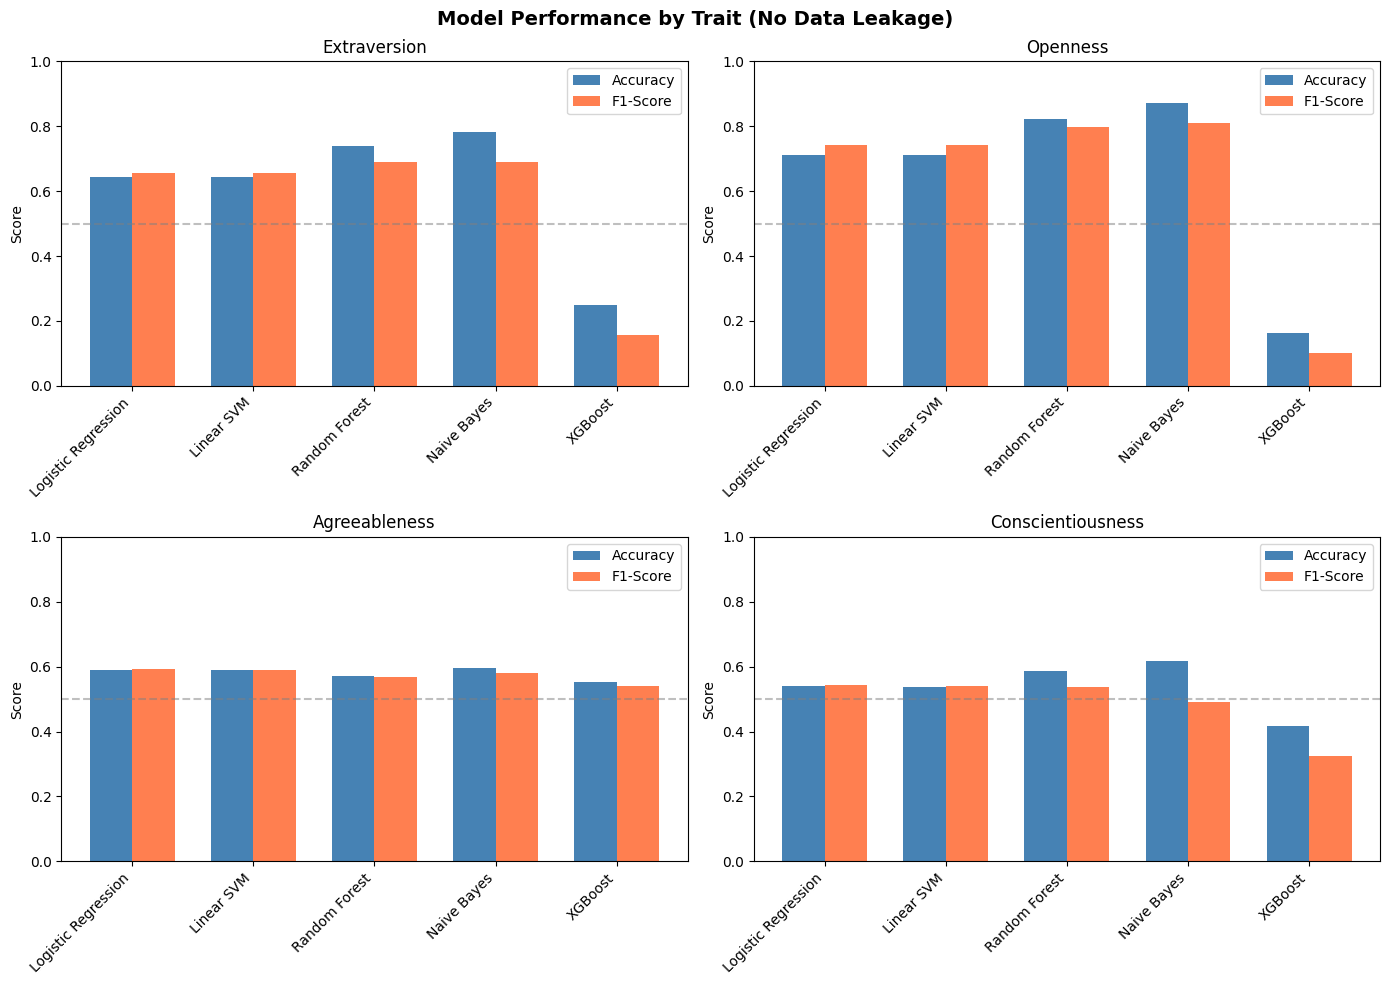

In [12]:
# ============================================
# 📊 DETAILED RESULTS PER TRAIT
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx]
    df_result = all_results[trait]
    
    x = np.arange(len(df_result))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_result['Accuracy'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, df_result['F1-Score'], width, label='F1-Score', color='coral')
    
    ax.set_ylabel('Score')
    ax.set_title(f'{trait}')
    ax.set_xticks(x)
    ax.set_xticklabels(df_result['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.suptitle('Model Performance by Trait (No Data Leakage)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

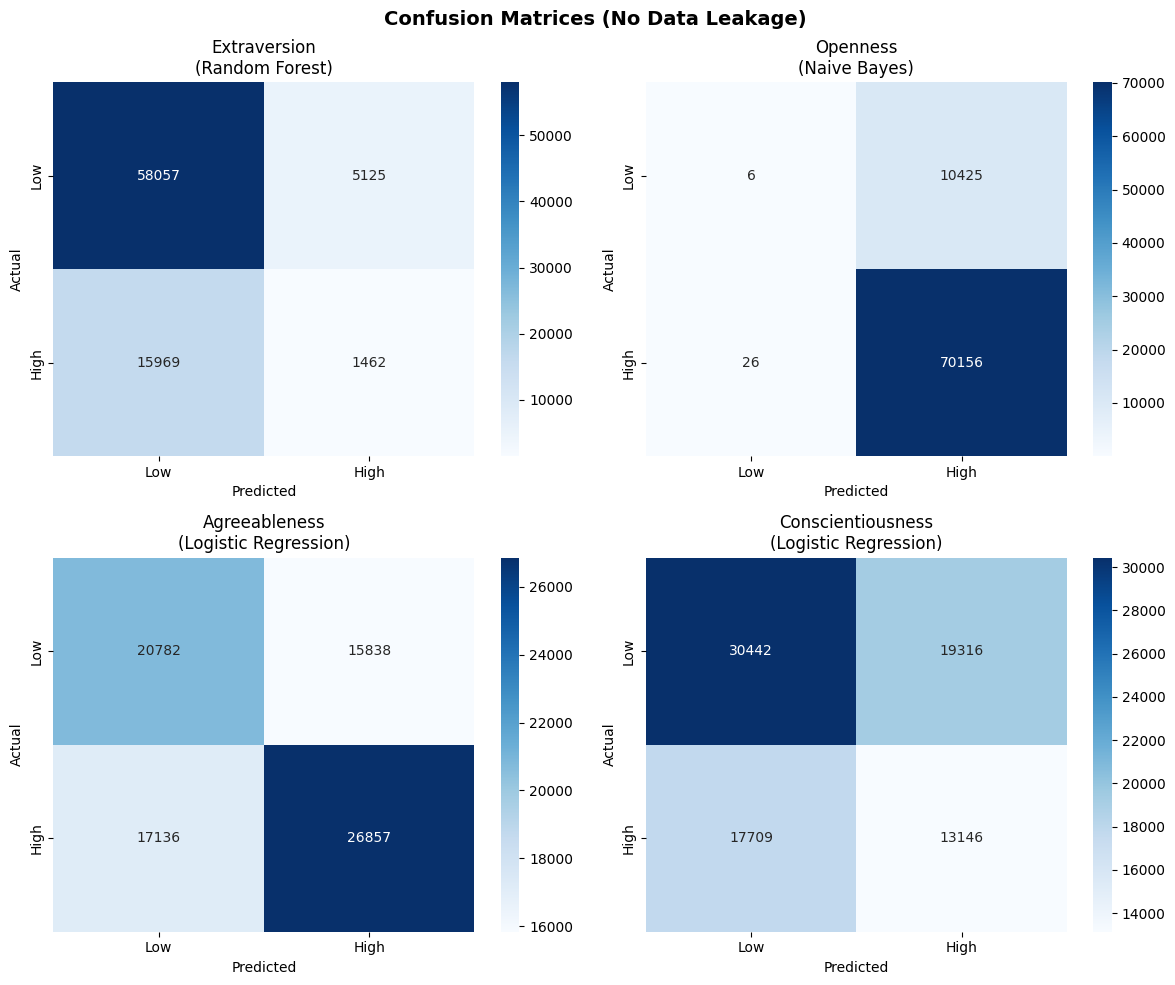

In [13]:
# ============================================
# 📋 CONFUSION MATRICES
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, trait in enumerate(TARGET_TRAITS):
    ax = axes[idx]
    best_name, best_model = best_models[trait]
    
    y_test = df_test[trait].values
    y_pred = best_model.predict(X_test_tfidf)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    ax.set_title(f'{trait}\n({best_name})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices (No Data Leakage)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# ============================================
# 📝 CLASSIFICATION REPORTS
# ============================================
print("\n" + "="*70)
print("📝 DETAILED CLASSIFICATION REPORTS")
print("="*70)

for trait in TARGET_TRAITS:
    print(f"\n🎯 {trait} ({best_models[trait][0]}):")
    print("-" * 50)
    
    best_model = best_models[trait][1]
    y_test = df_test[trait].values
    y_pred = best_model.predict(X_test_tfidf)
    
    print(classification_report(y_test, y_pred, target_names=['Low', 'High']))


📝 DETAILED CLASSIFICATION REPORTS

🎯 Extraversion (Random Forest):
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.78      0.92      0.85     63182
        High       0.22      0.08      0.12     17431

    accuracy                           0.74     80613
   macro avg       0.50      0.50      0.48     80613
weighted avg       0.66      0.74      0.69     80613


🎯 Openness (Naive Bayes):
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.19      0.00      0.00     10431
        High       0.87      1.00      0.93     70182

    accuracy                           0.87     80613
   macro avg       0.53      0.50      0.47     80613
weighted avg       0.78      0.87      0.81     80613


🎯 Agreeableness (Logistic Regression):
--------------------------------------------------
              precision    recall  f1-score   support

   

---
## 5. 🔍 So sánh với Notebook gốc


In [16]:
# ============================================
# 🔍 SO SÁNH VỚI NOTEBOOK GỐC
# ============================================

# Kết quả từ notebook gốc (copied from saved outputs)
# Updated to match the actual run results in personality_classification_colab.ipynb
original_results = {
    'Extraversion': {'Accuracy': 0.755043, 'F1-Score': 0.759286},
    'Openness': {'Accuracy': 0.831700, 'F1-Score': 0.835562},
    'Agreeableness': {'Accuracy': 0.778098, 'F1-Score': 0.778456},
    'Conscientiousness': {'Accuracy': 0.647839, 'F1-Score': 0.647794}
}

print("\n" + "="*80)
print("🔍 SO SÁNH: NOTEBOOK GỐC vs NO DATA LEAKAGE")
print("="*80)
print(f"{'Trait':<20} {'Original Acc':<15} {'No Leakage Acc':<18} {'Difference':<12}")
print("-"*80)

for trait in TARGET_TRAITS:
    orig_acc = original_results[trait]['Accuracy']
    new_acc = summary_df[summary_df['Trait'] == trait]['Accuracy'].values[0]
    diff = new_acc - orig_acc
    sign = '+' if diff > 0 else ''
    print(f"{trait:<20} {orig_acc:<15.4f} {new_acc:<18.4f} {sign}{diff:<12.4f}")

print("-"*80)
orig_avg = np.mean([v['Accuracy'] for v in original_results.values()])
new_avg = summary_df['Accuracy'].mean()
print(f"{'AVERAGE':<20} {orig_avg:<15.4f} {new_avg:<18.4f} {'+' if new_avg-orig_avg > 0 else ''}{new_avg-orig_avg:<12.4f}")


🔍 SO SÁNH: NOTEBOOK GỐC vs NO DATA LEAKAGE
Trait                Original Acc    No Leakage Acc     Difference  
--------------------------------------------------------------------------------
Extraversion         0.7550          0.7383             -0.0167     
Openness             0.8317          0.8704             +0.0387      
Agreeableness        0.7781          0.5910             -0.1871     
Conscientiousness    0.6478          0.5407             -0.1071     
--------------------------------------------------------------------------------
AVERAGE              0.7532          0.6851             -0.0681     


---
## 6. 📝 Kết luận

### Những thay đổi chính:
1. **Tách posts riêng lẻ**: Mỗi post là 1 sample thay vì gộp 50 posts/user
2. **Group-based split**: Sử dụng `GroupShuffleSplit` để đảm bảo không có user nào xuất hiện ở cả train và test
3. **Fit TF-IDF chỉ trên train**: Tránh information leakage từ test vocabulary

### Kỳ vọng:
- **Accuracy giảm**: Vì model không còn có thể "gian lận" bằng cách học writing style của từng user
- **Kết quả thực tế hơn**: Phản ánh đúng khả năng generalization của model trên users mới

### Ý nghĩa:
- Nếu accuracy giảm đáng kể → Notebook gốc có **data leakage nghiêm trọng**
- Nếu accuracy tương đương → Model thực sự học được personality patterns
